In [1]:
import pandas as pd
import numpy as np
from math import *
from scipy.special import lambertw
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.collections import PolyCollection
from scipy.interpolate import interp1d
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec

In [2]:
!pip install GitPython

In [3]:
from git import Repo
!git clone https://github.com/MariiaKalinina/BM.git

fatal: destination path 'BM' already exists and is not an empty directory.


In [4]:
import pandas as pd

file_path = '/content/BM/Initial data/Literature database from PM for all rock lithotypes.xlsx'

database = pd.ExcelFile(file_path)
print("Available sheets:", database.sheet_names)

for sheet_name in database.sheet_names:
    clean_name = sheet_name.replace(" ", "_").replace("-", "_")
    var_name = f"Database_{clean_name}"

    # Assign the DataFrame to a dynamically named variable
    globals()[var_name] = pd.read_excel(
        file_path,
        sheet_name=sheet_name,
        header=0
    )
    print(f"Created variable: {var_name}")

Available sheets: ['Lithotypes', 'Kinetics all', 'Secondary cracking', 'Geochronology', 'SWIT_Map', 'SWIT_coordinates ', 'Global eustatic curve']
Created variable: Database_Lithotypes
Created variable: Database_Kinetics_all
Created variable: Database_Secondary_cracking
Created variable: Database_Geochronology
Created variable: Database_SWIT_Map
Created variable: Database_SWIT_coordinates_
Created variable: Database_Global_eustatic_curve


# Geochronology timescale

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_geological_timescale(df, min_age=0, max_age=160, figsize=(16, 1)):
    """
    Plot a geological timescale with periods and epochs.

    Parameters:
    - df: DataFrame containing geochronology data
    - min_age: Minimum age (youngest) to display (default: 0 Ma)
    - max_age: Maximum age (oldest) to display (default: 160 Ma)
    - figsize: Figure size (default: (16, 1))
    """
    # Make a copy of the dataframe to avoid modifying the original
    df = Database_Geochronology.copy()

    # Rename key columns
    column_map = {
        'System/ Period': 'Period',
        'Series / Epoch': 'Epoch',
        'Numerical age top ': 'Age_top',
        'Numerical age bottom': 'Age_bottom',
        'R.2': 'Period_R', 'G.2': 'Period_G', 'B.2': 'Period_B',
        'R.4': 'Epoch_R', 'G.4': 'Epoch_G', 'B.4': 'Epoch_B'
    }
    df = df.rename(columns=column_map)

    # Convert age columns to numeric
    df['Age_top'] = pd.to_numeric(df['Age_top'], errors='coerce')
    df['Age_bottom'] = pd.to_numeric(df['Age_bottom'], errors='coerce')

    # Filter for the specified age range
    df = df[(df['Age_bottom'] <= max_age) & (df['Age_top'] >= min_age)].copy()

    # Function to get consolidated periods with unique epochs
    def get_consolidated_periods():
        periods = []
        for period, group in df.groupby('Period'):
            if pd.isna(period) or period == '-':
                continue

            period_top = group['Age_top'].min()
            period_bottom = group['Age_bottom'].max()
            period_rgb = (group['Period_R'].iloc[0],
                          group['Period_G'].iloc[0],
                          group['Period_B'].iloc[0])

            periods.append({
                'name': period,
                'top': period_top,
                'bottom': period_bottom,
                'rgb': period_rgb
            })

        # Get unique epochs
        epoch_df = df[df['Epoch'].notna() & (df['Epoch'] != '-')].copy()
        unique_epochs = []
        for epoch, group in epoch_df.groupby('Epoch'):
            epoch_top = group['Age_top'].min()
            epoch_bottom = group['Age_bottom'].max()
            epoch_rgb = (group['Epoch_R'].iloc[0],
                         group['Epoch_G'].iloc[0],
                         group['Epoch_B'].iloc[0])

            unique_epochs.append({
                'name': epoch,
                'top': epoch_top,
                'bottom': epoch_bottom,
                'rgb': epoch_rgb
            })

        return periods, unique_epochs

    periods, unique_epochs = get_consolidated_periods()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize,
                                  gridspec_kw={'height_ratios': [1, 1]},
                                  sharex=True)

    # Plot Periods (top panel)
    for period in periods:
        color = tuple(c/255 for c in period['rgb'])
        width = period['top'] - period['bottom']
        rect = patches.Rectangle(
            (period['bottom'], 0),
            width,
            1,
            linewidth=0.5, edgecolor='black', facecolor=color
        )
        ax1.add_patch(rect)

        # Add period label (full name if width > 20, otherwise first 3 letters)
        if abs(width) > 2:
            display_text = period['name']
            ax1.text(
                period['bottom'] + width/2, 0.5, display_text,
                ha='center', va='center', color='black', fontsize=10,
            )
        elif abs(width) < 5:  # For narrower periods, show first 3 letters
            display_text = period['name'][:3]
            ax1.text(
                period['bottom'] + width/2, 0.5, display_text,
                ha='center', va='center', color='black', fontsize=14,
            )

    # Plot unique Epochs (bottom panel)
    for epoch in unique_epochs:
        color = tuple(c/255 for c in epoch['rgb'])
        width = epoch['top'] - epoch['bottom']
        rect = patches.Rectangle(
            (epoch['bottom'], 0),
            width,
            1,
            linewidth=0.5, edgecolor='black', facecolor=color
        )
        ax2.add_patch(rect)

        # Add epoch label (first 3 letters if width > 10)
        if abs(width) > 3:
            display_text = epoch['name'][:3]  # Only first 3 letters for epochs
            ax2.text(
                abs(epoch['bottom'] + width/2), 0.5, display_text,
                ha='center', va='center', color='black', fontsize=8,
            )

    # Configure axes
    for ax in [ax1, ax2]:
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.spines[['left', 'right', 'top']].set_visible(False)
        ax.grid(axis='x', linestyle=':', alpha=0.3)
        ax.set_xlim(max_age, min_age)  # Geological time goes from old to young

    ax2.set_xlabel('Millions of years ago (Ma)', fontsize=10)
    plt.show()

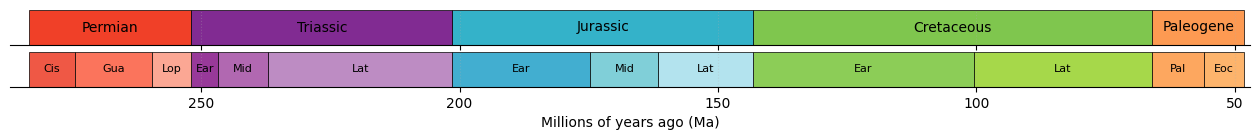

In [6]:
# Example usage:
plot_geological_timescale(Database_Geochronology, min_age=47, max_age=287)

# Burial history with X property and Geochronology timescale

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.collections import PolyCollection, PathCollection
from scipy.interpolate import interp1d
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from typing import Tuple, Dict, Optional, Union
from IPython.display import Image

In [8]:
# Словарь для перевода литологических типов
LITHOLOGY_TRANSLATION = {
    'Sandstone (typical)': 'Песчаник',
    'Shale (typical)': 'Глинистые/n породы',
    'Limestone (organic rich - typical)': 'Известняк',
    'Dolomite (typical)': 'Доломит',
    'Quartzite': 'Кварцит',
    'Salt': 'Соль',
    'Chalk (typical)': 'Мел',
    'Anhydrite': 'Ангидрит',
}

COLUMN_MAP = {
    'System/ Period': 'Period',
    'Series / Epoch': 'Epoch',
    'Numerical age top ': 'Age_top',
    'Numerical age bottom': 'Age_bottom',
    'R.2': 'Period_R', 'G.2': 'Period_G', 'B.2': 'Period_B',
    'R.4': 'Epoch_R', 'G.4': 'Epoch_G', 'B.4': 'Epoch_B'
}


In [42]:
class GeologicalPlotter:
    """Класс для построения геологических графиков с историей погружения."""

    def __init__(self):
        self.lithology_colors = {}

    def _safe_convert_to_float(self, x: Union[str, float]) -> float:
        """Безопасное преобразование в float."""
        try:
            return float(x)
        except (ValueError, TypeError):
            return np.nan

    def _prepare_geochronology_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Подготовка данных геохронологии."""
        df = df.copy().rename(columns=COLUMN_MAP)
        df['Age_top'] = pd.to_numeric(df['Age_top'], errors='coerce')
        df['Age_bottom'] = pd.to_numeric(df['Age_bottom'], errors='coerce')
        return df

    def _prepare_property_data(self, data_df: pd.DataFrame, decompaction_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, np.ndarray]:
        """Подготовка данных свойств и декомпакции."""
        data_df = data_df.copy()
        data_df.columns = [self._safe_convert_to_float(col) for col in data_df.columns]
        data_df = data_df.sort_index(axis=1).dropna(axis=1, how='all')

        decompaction_df = decompaction_df.copy()
        decompaction_df.columns = [str(self._safe_convert_to_float(col)) for col in decompaction_df.columns]
        decompaction_df = decompaction_df.sort_index(axis=1).dropna(axis=1, how='all')

        ages = np.array(data_df.columns)
        return data_df, decompaction_df, ages

    def _create_interpolated_grid(self, layer_idx: int, ages: np.ndarray,
                                 decompaction_df: pd.DataFrame, data_df: pd.DataFrame,
                                 n_interp: int = 1000) -> Tuple[Optional[np.ndarray], ...]:
        """Создание интерполированной сетки для одного слоя."""
        depth_values = np.array([decompaction_df.loc[layer_idx, str(age)]
                               if str(age) in decompaction_df.columns
                               else np.nan for age in ages]) * 1000
        prop_values = data_df.loc[layer_idx].values

        valid_mask = ~np.isnan(depth_values) & ~np.isnan(prop_values)
        if sum(valid_mask) < 2:
            return None, None, None

        valid_ages = ages[valid_mask]
        valid_depths = depth_values[valid_mask]
        valid_props = prop_values[valid_mask]

        depth_interp = interp1d(valid_ages, valid_depths, kind='linear',
                               fill_value="interpolate", assume_sorted=True)
        prop_interp = interp1d(valid_ages, valid_props, kind='linear',
                              fill_value="interpolate", assume_sorted=True) #extrapolate

        interp_ages = np.linspace(ages.min(), ages.max(), n_interp)
        interp_depths = depth_interp(interp_ages)
        interp_props = prop_interp(interp_ages)

        return interp_ages, interp_depths, interp_props

    def _calculate_color_range(self, data_df: pd.DataFrame, vmin: Optional[float],
                             vmax: Optional[float]) -> Tuple[float, float]:
        """Вычисление диапазона значений для цветовой шкалы."""
        all_values = data_df.values.flatten()
        all_values = all_values[~np.isnan(all_values)]

        if vmin is None:
            vmin = np.percentile(all_values, 5)
        if vmax is None:
            vmax = np.percentile(all_values, 95)

        return vmin, vmax

    def _plot_geological_column(self, ax_geo: plt.Axes, data_df: pd.DataFrame,
                              decompaction_df: pd.DataFrame, valid_layers_df: pd.DataFrame):
        """Построение геологической колонки."""
        # Инициализация цветов для литологии
        lithologies = valid_layers_df['Lithology_type'].unique()
        self.lithology_colors = {lith: plt.cm.tab20(i/len(lithologies))
                               for i, lith in enumerate(lithologies)}

        # Находим столбец, ближайший к современности
        present_col = min(decompaction_df.columns,
                         key=lambda x: abs(float(x)) if str(float(x)) == x else float('inf'))

        # Рисуем геологическую колонку
        prev_depth = 0
        for layer_idx, _ in data_df.iterrows():
            try:
                current_depth = decompaction_df.loc[layer_idx, present_col] * 1000
                if np.isnan(current_depth):
                    continue

                lithology = valid_layers_df.loc[layer_idx, 'Lithology_type']
                lithology_ru = LITHOLOGY_TRANSLATION.get(lithology, lithology)
                color = self.lithology_colors[lithology]

                # Линия связи (убрана из этой функции, так как требует доступа к ax_main)

                # Слой в колонке
                ax_geo.fill_betweenx([prev_depth, current_depth], 0, 1,
                                   color=color, alpha=0.7)

                # Подпись литологии
                if (current_depth - prev_depth) > 100:
                    ax_geo.text(0.5, (prev_depth + current_depth)/2,
                               lithology_ru,
                               ha='center', va='center',
                               fontsize=9 if len(lithology_ru) < 10 else 7)

                prev_depth = current_depth

            except (KeyError, ValueError, TypeError):
                continue

    def plot_geological_timescale(self, df: pd.DataFrame, min_age: float,
                                max_age: float, fig: Optional[plt.Figure] = None,
                                axs: Optional[Tuple[plt.Axes, plt.Axes]] = None) -> Tuple[plt.Figure, Tuple[plt.Axes, plt.Axes]]:
        """
        Построение геохронологической шкалы с периодами и эпохами.
        """
        df = self._prepare_geochronology_data(df)
        df = df[(df['Age_bottom'] <= max_age) & (df['Age_top'] >= min_age)].copy()

        # Получение данных периодов и эпох
        periods = self._get_consolidated_periods(df)
        epochs = self._get_unique_epochs(df)

        # Создание фигуры и осей при необходимости
        if fig is None:
            fig = plt.figure(figsize=(12, 2))

        if axs is None:
            gs = GridSpec(2, 1, height_ratios=[0.5, 0.5], hspace=0.05)
            ax1 = fig.add_subplot(gs[0])  # Периоды
            ax2 = fig.add_subplot(gs[1])  # Эпохи
        else:
            ax1, ax2 = axs

        # Построение периодов
        self._plot_time_intervals(ax1, periods, is_epoch=False)

        # Построение эпох
        self._plot_time_intervals(ax2, epochs, is_epoch=True)

        # Настройка осей
        for ax in [ax1, ax2]:
            ax.set_ylim(0, 1)
            ax.set_yticks([])
            ax.spines[['left', 'right', 'top']].set_visible(False)
            ax.grid(axis='x', linestyle=':', alpha=0.3)
            ax.set_xlim(max_age, min_age)

        ax1.set_xticks([])
        ax2.set_xticks([])
        ax2.set_xlabel('Геологическое время [млн лет]', fontsize=10)

        return fig, (ax1, ax2)

    def _get_consolidated_periods(self, df: pd.DataFrame) -> list:
        """Получение консолидированных данных по периодам."""
        periods = []
        for period, group in df.groupby('Period'):
            if pd.isna(period) or period == '-':
                continue

            periods.append({
                'name': period,
                'top': group['Age_top'].min(),
                'bottom': group['Age_bottom'].max(),
                'rgb': (group['Period_R'].iloc[0],
                        group['Period_G'].iloc[0],
                        group['Period_B'].iloc[0])
            })
        return periods

    def _get_unique_epochs(self, df: pd.DataFrame) -> list:
        """Получение уникальных эпох."""
        epoch_df = df[df['Epoch'].notna() & (df['Epoch'] != '-')].copy()
        unique_epochs = []

        for epoch, group in epoch_df.groupby('Epoch'):
            unique_epochs.append({
                'name': epoch,
                'top': group['Age_top'].min(),
                'bottom': group['Age_bottom'].max(),
                'rgb': (group['Epoch_R'].iloc[0],
                        group['Epoch_G'].iloc[0],
                        group['Epoch_B'].iloc[0]),
                'width': group['Age_top'].min() - group['Age_bottom'].max()
            })
        return unique_epochs

    def _plot_time_intervals(self, ax: plt.Axes, intervals: list, is_epoch: bool = False):
        """Построение интервалов времени (периодов или эпох)."""
        for interval in intervals:
            color = tuple(c/255 for c in interval['rgb'])
            width = interval['top'] - interval['bottom']

            rect = patches.Rectangle(
                (interval['bottom'], 0),
                width,
                1,
                linewidth=0.5, edgecolor='black', facecolor=color
            )
            ax.add_patch(rect)

            # Добавление подписи
            if is_epoch:
                display_text = (interval['name'].split()[0] if abs(width) > 15
                              else interval['name'].split()[0][:3] + '.')
                fontsize = 6
            else:
                display_text = (interval['name'] if abs(width) > 3
                              else interval['name'][:1])
                fontsize = 10

            ax.text(
                interval['bottom'] + width/2, 0.5, display_text,
                ha='center', va='center', color='black', fontsize=fontsize
            )

    def plot_burial_history_with_property(self, data_df: pd.DataFrame,
                                        decompaction_df: pd.DataFrame,
                                        valid_layers_df: pd.DataFrame,
                                        geochronology_df: pd.DataFrame,
                                        property_name: str,
                                        unit: str,
                                        min_age: float,
                                        max_age: float,
                                        # min_age: float = 0,
                                        # max_age: float = 250,
                                        cmap: str = 'rainbow',
                                        figsize: Tuple[float, float] = (12, 8),
                                        output_filename: str = 'burial_history_plot.png',
                                        depth_range: Tuple[float, float] = (0, 5000),
                                        vmin: Optional[float] = None,
                                        vmax: Optional[float] = None) -> Image:
        """
        Построение истории погружения с цветовой кодировкой по свойству.
        """
        # Инициализация фигуры
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(3, 1, height_ratios=[0.05, 0.05, 1], hspace=0.0)

        # Панель геохронологической шкалы
        ax_periods = fig.add_subplot(gs[0])
        ax_epochs = fig.add_subplot(gs[1])
        self.plot_geological_timescale(geochronology_df, min_age=min_age, max_age=max_age,
                                     fig=fig, axs=(ax_periods, ax_epochs))

        # Основная панель с данными
        ax_main = fig.add_subplot(gs[2])

        # Подготовка данных
        data_df, decompaction_df, ages = self._prepare_property_data(data_df, decompaction_df)
        vmin, vmax = self._calculate_color_range(data_df, vmin, vmax)

        prop_cmap = plt.colormaps.get_cmap(cmap)
        norm = plt.Normalize(vmin=vmin, vmax=vmax)

        # Построение полигонов
        sc = self._plot_property_polygons(ax_main, data_df, decompaction_df, ages, prop_cmap, norm)

        # Геологическая колонка
        ax_geo = ax_main.inset_axes([1.02, 0, 0.15, 1], transform=ax_main.transAxes)
        ax_geo.set_xlim(0, 1)
        ax_geo.set_xticks([])
        ax_geo.set_xticklabels([])
        ax_geo.xaxis.set_label_position('top')
        ax_geo.set_xlabel('Литологическая\nколонка', fontsize=12, labelpad=25)
        ax_geo.grid(False)

        self._plot_geological_column(ax_geo, data_df, decompaction_df, valid_layers_df)

        # Добавление линий связи между колонкой и графиком
        present_col = min(decompaction_df.columns,
                         key=lambda x: abs(float(x)) if str(float(x)) == x else float('inf'))

        for layer_idx, _ in data_df.iterrows():
            try:
                current_depth = decompaction_df.loc[layer_idx, present_col] * 1000
                if not np.isnan(current_depth):
                    ax_main.plot([float(present_col), 0.87],
                                [current_depth, current_depth],
                                'k--', lw=0.5, alpha=0.35, zorder=1)
            except (ValueError, KeyError):
                continue

        # Настройка осей
        ax_main.set_xlim(max_age, min_age)
        ax_main.set_ylim(depth_range[1], depth_range[0])
        ax_main.set_xlabel('Геологическое время [млн лет]', fontsize=12, labelpad=2.5)
        ax_main.set_ylabel('Глубина [м]', fontsize=12)
        ax_main.grid(True, linestyle=':', linewidth=0.5, alpha=0.2, color='gray')
        ax_main.tick_params(axis='both', which='major', labelsize=10)

        # Цветовая шкала
        cax = ax_main.inset_axes([0, -0.15, 1, 0.05], transform=ax_main.transAxes)
        cbar = plt.colorbar(sc, cax=cax, orientation='horizontal')
        cbar.set_label(f'{property_name} [{unit}]', fontsize=12)
        cbar.ax.tick_params(labelsize=10)

        # Убираем ось Y для геологической колонки
        ax_geo.yaxis.set_visible(False)
        ax_geo.set_ylim(ax_main.get_ylim())

        # Сохранение и отображение
        plt.savefig(output_filename, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()

        return Image(filename=output_filename)

    def _plot_property_polygons(self, ax: plt.Axes, data_df: pd.DataFrame,
                              decompaction_df: pd.DataFrame, ages: np.ndarray,
                              cmap, norm) -> PathCollection:
        """Построение полигонов для отображения свойства с улучшенным сглаживанием."""
        sc = None

        # Создадим общий массив для интерполяции по всем возрастам
        common_ages = np.linspace(ages.min(), ages.max(), 200)  # Увеличим количество точек

        # Интерполируем все слои на общую сетку
        all_depths = []
        all_props = []

        for layer_idx in data_df.index:
            ages_i, depths_i, props_i = self._create_interpolated_grid(
                layer_idx, ages, decompaction_df, data_df, n_interp=200)

            if ages_i is not None:
                # Интерполируем на общую сетку возрастов
                depth_interp = interp1d(ages_i, depths_i, kind='linear',
                                      fill_value="extrapolate")
                prop_interp = interp1d(ages_i, props_i, kind='linear',
                                    fill_value="extrapolate")

                all_depths.append(depth_interp(common_ages))
                all_props.append(prop_interp(common_ages))

        if not all_depths:
            return None

        # Добавим поверхностный слой (0.5 м)
        surface_prop = data_df.iloc[0].values
        surface_prop_func = interp1d(ages, surface_prop, kind='linear',
                                  fill_value="extrapolate")
        surface_props = surface_prop_func(common_ages)
        surface_depths = np.full_like(common_ages, 0.5)  # Поверхность на 0.5 м

        # Начинаем с поверхностного слоя
        prev_depths = surface_depths
        prev_props = surface_props

        # Построение полигонов между слоями
        for curr_depths, curr_props in zip(all_depths, all_props):
            polygons = []
            color_values = []

            for j in range(len(common_ages)-1):
                # Используем билинейную интерполяцию для более плавных переходов
                avg_prop = (prev_props[j] + prev_props[j+1] +
                          curr_props[j] + curr_props[j+1]) / 4

                poly_verts = [
                    (common_ages[j], prev_depths[j]),
                    (common_ages[j+1], prev_depths[j+1]),
                    (common_ages[j+1], curr_depths[j+1]),
                    (common_ages[j], curr_depths[j])
                ]
                polygons.append(poly_verts)
                color_values.append(avg_prop)

            if polygons:
                poly_collection = PolyCollection(
                    polygons,
                    array=np.array(color_values),
                    cmap=cmap,
                    norm=norm,
                    # alpha=0.8,  # Увеличим прозрачность для лучшего смешения
                    edgecolor='none',  # Убираем границы полностью
                    linewidth=0,
                    zorder=2
                )
                ax.add_collection(poly_collection)

            prev_depths = curr_depths
            prev_props = curr_props

        # Точечные данные для точного отображения значений
        for layer_idx, layer_row in data_df.iterrows():
            depth_values = np.array([decompaction_df.loc[layer_idx, str(age)]
                                if str(age) in decompaction_df.columns
                                else np.nan for age in ages]) * 1000
            sc = ax.scatter(ages, depth_values,
                        c=layer_row.values,
                        cmap=cmap,
                        norm=norm,
                        s=0,  # Увеличим размер точек
                        edgecolor='none',  # Убираем границы у точек
                        alpha=1,
                        zorder=3)

        return sc

## Input data

In [43]:
VALID_LAYERS = pd.read_excel('/content/valid_layers.xlsx')

In [44]:
AGES = sorted(VALID_LAYERS['Age (Ma)'].unique(), reverse=True)

In [25]:
BURIAL_DEPTH= pd.read_excel('/content/decompaction_corrected_df.xlsx')

In [26]:
PORE_PRESSURE = pd.read_excel('/content/PORE_PRESSURE_DATA.xlsx')

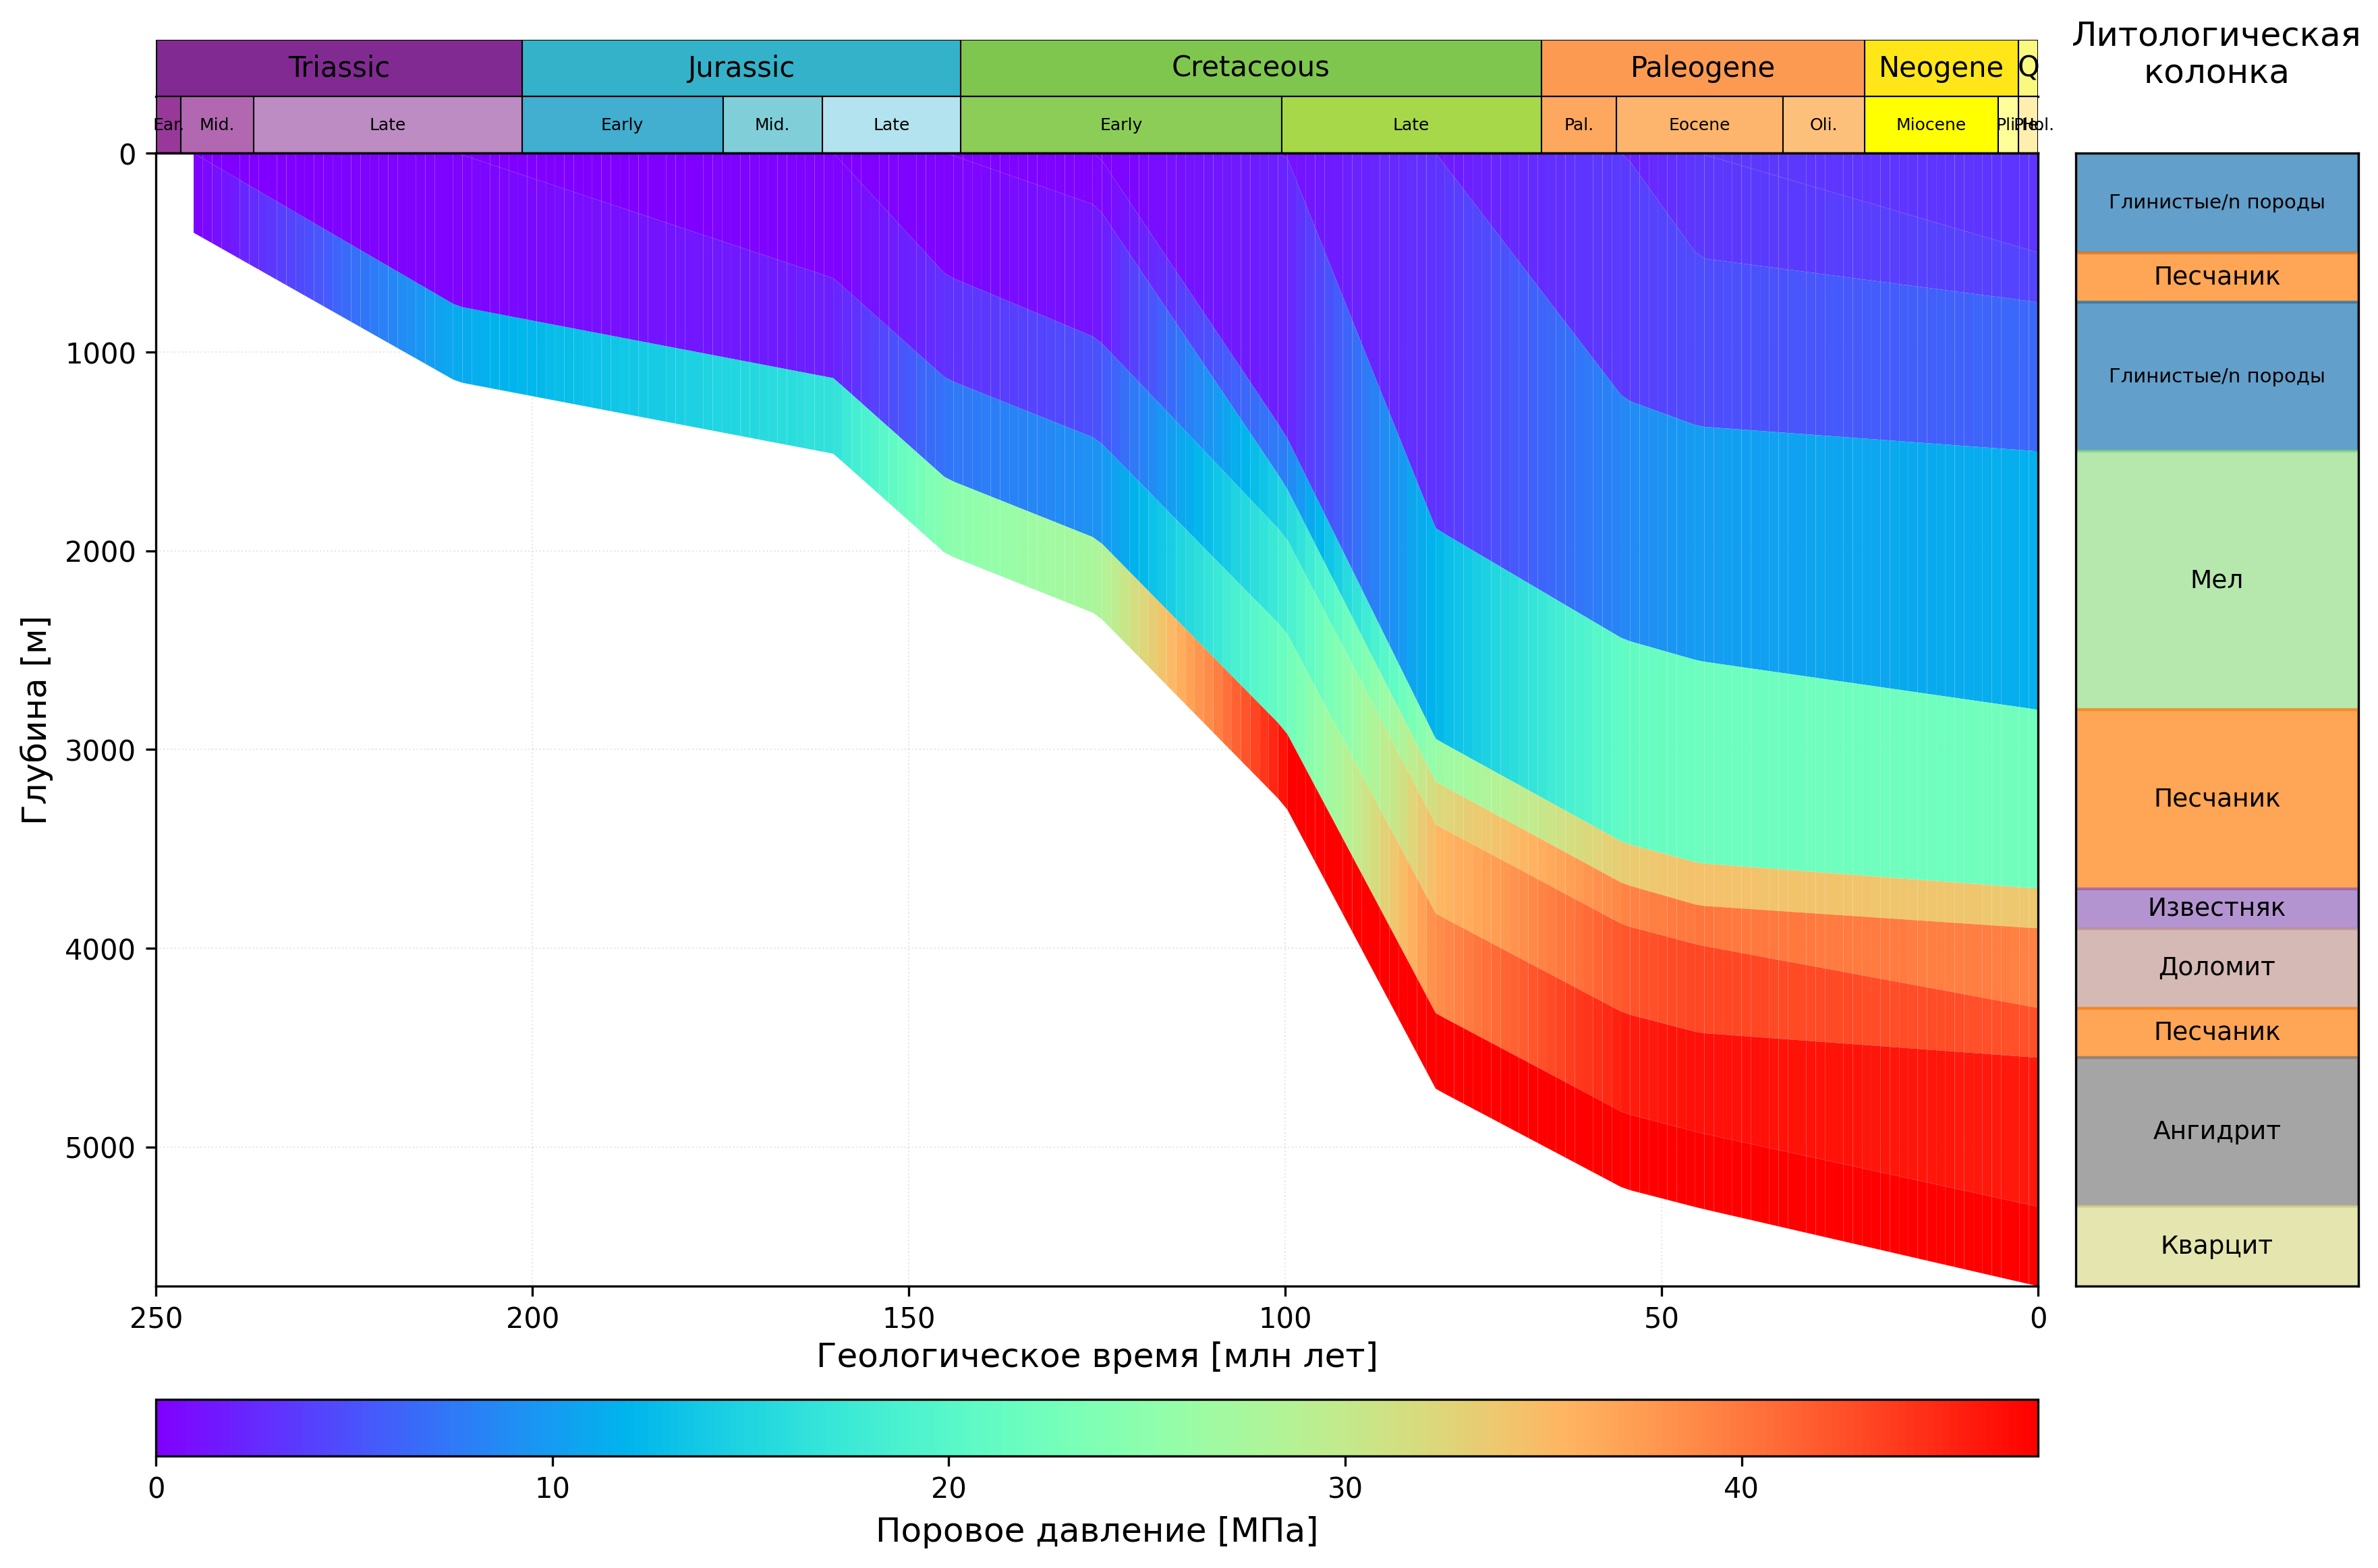

In [53]:
plotter = GeologicalPlotter()
plotter.plot_burial_history_with_property(
    data_df=PORE_PRESSURE,
    decompaction_df=BURIAL_DEPTH,
    valid_layers_df=valid_layers,
    geochronology_df=Database_Geochronology,
    property_name="Поровое давление",
    unit="МПа",
    min_age=min(AGES), # min_age=0,
    max_age=250, # max_age=250,
    cmap='rainbow',
    figsize=(12, 8),
    output_filename='pore_pressure_history.png',
    depth_range=(0, 5700)
)